In [1]:
from tqdm import tqdm   

import numpy as np
import pandas as pd
from datasets import load_dataset

import dl_translate as dlt

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM, pipeline

import huggingface_hub
huggingface_hub.login() # now you will be prompted to enter your token; enter it.

In [ ]:
!python -m spacy download en_core_web_lg
import spacy
import spacy_transformers
import torch

tqdm.pandas()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 5.3 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


# English processing use cases
This notebook aims to test the Task and Object identification in patents in english.

1. **Task:** the method used in the described patent. In can be compress something or agilize a effect, for example.
2. **Object:** the "target" of the task. It can be a food, a construction material or any other object that, combined with the task, defines the patent.

It is supposed that NLP techniques are more refined to english data as the models are well-developed and to validate this theory, all the patents will be translated to english to them be processed.

[DL-Translate](https://pypi.org/project/dl-translate/), a Python library that implements a low verbosity use of many open source models to translation tasks.

Three models can be used to translate from portuguese to english:
- [mBART-50 Large](https://huggingface.co/transformers/master/model_doc/mbart.html): Allows translations across 50 languages.
- [m2m100](https://huggingface.co/docs/transformers/model_doc/m2m_100): Allows translations across 100 languages.
- [nllb-200](https://huggingface.co/docs/transformers/model_doc/nllb): Allows translations across 200 languages, and is faster than m2m100 (On RTX A6000, we can see speed up of 3x).

# Model translation evaluation

To test the models we will evaluate using [FLORES+](https://huggingface.co/datasets/openlanguagedata/flores_plus) from Meta and evaluate the BLEU score for each model. This will serve as a benchmark to choose the best translating model to portuguese.

To do so, we have to download the portuguese and english bases and combine then by the ID.

In [3]:
ds_por = load_dataset("openlanguagedata/flores_plus", "por_Latn")
ds_por_df = ds_por['dev'].to_pandas()
ds_por_df.head()

Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

,id,iso_639_3,iso_15924,glottocode,text,url,domain,topic,has_image,has_hyperlink,last_updated
0,0,por,Latn,braz1246,"Na segunda-feira, cientistas da Escola de Medi...",https://en.wikinews.org/wiki/Scientists_say_ne...,wikinews,health,yes,yes,1.0
1,1,por,Latn,braz1246,Os principais pesquisadores dizem que isso pod...,https://en.wikinews.org/wiki/Scientists_say_ne...,wikinews,health,yes,yes,1.0
2,2,por,Latn,braz1246,O JAS 39 Gripen se chocou com a pista por volt...,https://en.wikinews.org/wiki/Fighter_jet_crash...,wikinews,accident,yes,yes,1.0
3,3,por,Latn,braz1246,O piloto foi identificado como o Líder de Esqu...,https://en.wikinews.org/wiki/Fighter_jet_crash...,wikinews,accident,yes,yes,1.0
4,4,por,Latn,braz1246,A mídia local informa o capotamento de um veíc...,https://en.wikinews.org/wiki/Fighter_jet_crash...,wikinews,accident,yes,yes,1.0


In [4]:
ds_en = load_dataset("openlanguagedata/flores_plus", "eng_Latn")
ds_en_df = ds_en['dev'].to_pandas()
ds_en_df.head()

Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

,id,iso_639_3,iso_15924,glottocode,text,url,domain,topic,has_image,has_hyperlink,last_updated
0,0,eng,Latn,stan1293,"On Monday, scientists from the Stanford Univer...",https://en.wikinews.org/wiki/Scientists_say_ne...,wikinews,health,yes,yes,1.0
1,1,eng,Latn,stan1293,Lead researchers say this may bring early dete...,https://en.wikinews.org/wiki/Scientists_say_ne...,wikinews,health,yes,yes,1.0
2,2,eng,Latn,stan1293,The JAS 39C Gripen crashed onto a runway at ar...,https://en.wikinews.org/wiki/Fighter_jet_crash...,wikinews,accident,yes,yes,1.0
3,3,eng,Latn,stan1293,The pilot was identified as Squadron Leader Di...,https://en.wikinews.org/wiki/Fighter_jet_crash...,wikinews,accident,yes,yes,1.0
4,4,eng,Latn,stan1293,Local media reports an airport fire vehicle ro...,https://en.wikinews.org/wiki/Fighter_jet_crash...,wikinews,accident,yes,yes,1.0


In [5]:
id = 0
print(f"English: {ds_en_df.loc[ds_en_df['id'] == id]['text'].values[0]}")
print(f"Portuguese: {ds_por_df.loc[ds_por_df['id'] == id]['text'].values[0]}")

English: On Monday, scientists from the Stanford University School of Medicine announced the invention of a new diagnostic tool that can sort cells by type: a tiny printable chip that can be manufactured using standard inkjet printers for possibly about one U.S. cent each.
Portuguese: Na segunda-feira, cientistas da Escola de Medicina da Universidade de Stanford anunciaram a invenção de uma nova ferramenta de diagnóstico que pode classificar células por tipo: um minúsculo chip imprimível que pode ser fabricado usando impressoras jato de tinta padrão por possivelmente cerca de um centavo de dólar cada.


In [6]:
df_merged = ds_por_df[['id', 'text']].merge(
    ds_en_df[['id', 'text']],
    on='id',
    suffixes=('_pt', '_en')
)

df_merged.head()

,id,text_pt,text_en
0,0,"Na segunda-feira, cientistas da Escola de Medi...","On Monday, scientists from the Stanford Univer..."
1,1,Os principais pesquisadores dizem que isso pod...,Lead researchers say this may bring early dete...
2,2,O JAS 39 Gripen se chocou com a pista por volt...,The JAS 39C Gripen crashed onto a runway at ar...
3,3,O piloto foi identificado como o Líder de Esqu...,The pilot was identified as Squadron Leader Di...
4,4,A mídia local informa o capotamento de um veíc...,Local media reports an airport fire vehicle ro...


In [ ]:
df_merged = df_merged.head(5)

In [7]:
print(f"Size of the evaluation dataset: {len(df_merged)}")

Size of the evaluation dataset: 997


First, we will process the data with m2m model

In [8]:
import torch

device = 0 if torch.cuda.is_available() else -1
print(f"Using device: {device} as {'cuda' if device == 0 else 'cpu'}")

Using device: 0 as cuda


In [ ]:
col_name = "m2m100_translation"

if not df_merged.columns.str.contains(col_name).any():
    mt = dlt.TranslationModel(model_or_path="m2m100", device="cpu")


    df_merged[col_name] = df_merged["text_pt"].progress_apply(
        lambda x: mt.translate(x, source=dlt.lang.PORTUGUESE, target=dlt.lang.ENGLISH)
    )

    df_merged.to_csv("../../data/processed/translation_benchmark_flores_plus_pt_en.csv", index=False)
    df_merged.head()

100%|██████████| 997/997 [32:49<00:00,  1.98s/it]


,id,text_pt,text_en,m2m100_translation
0,0,"Na segunda-feira, cientistas da Escola de Medi...","On Monday, scientists from the Stanford Univer...","On Monday, scientists from the University of S..."
1,1,Os principais pesquisadores dizem que isso pod...,Lead researchers say this may bring early dete...,Lead researchers say that this can lead to ear...
2,2,O JAS 39 Gripen se chocou com a pista por volt...,The JAS 39C Gripen crashed onto a runway at ar...,The JAS 39 Gripen shocked with the track aroun...
3,3,O piloto foi identificado como o Líder de Esqu...,The pilot was identified as Squadron Leader Di...,The pilot was identified as the Squad Leader D...
4,4,A mídia local informa o capotamento de um veíc...,Local media reports an airport fire vehicle ro...,The local media the capture of a fire vehicle ...


Now mbart-50

In [ ]:
# Traduzindo os textos em português para inglês usando o modelo mbart50
col_name = "mbart50_translation"

if not df_merged.columns.str.contains(col_name).any():
    mt_mbart50 = dlt.TranslationModel(model_or_path="mbart50", device="cpu")
    df_merged[col_name] = df_merged["text_pt"].progress_apply(
        lambda x: mt_mbart50.translate(x, source=dlt.lang.PORTUGUESE, target=dlt.lang.ENGLISH)
    )

    df_merged.to_csv("../../data/processed/translation_benchmark_flores_plus_pt_en.csv", index=False)

100%|██████████| 997/997 [37:07<00:00,  2.23s/it]


Now unicamp-dl/translation-pt-en-t5

In [ ]:
col_name = "unicamp_pt_en_t5"

if not df_merged.columns.str.contains(col_name).any():
    tokenizer = AutoTokenizer.from_pretrained("unicamp-dl/translation-pt-en-t5")
    model = AutoModelForSeq2SeqLM.from_pretrained("unicamp-dl/translation-pt-en-t5")

    pt_en_pipeline = pipeline(
        "text2text-generation",
        model=model,
        tokenizer=tokenizer,
        device=device
    )

    df_merged[col_name] = df_merged["text_pt"].progress_apply(
        lambda x: pt_en_pipeline(f"translate Portuguese to English: {x}")[0]['generated_text']
    )

    df_merged.to_csv("../../data/processed/translation_benchmark_flores_plus_pt_en.csv", index=False)

Device set to use cuda:0
100%|██████████| 997/997 [06:15<00:00,  2.65it/s]


Now facebook/nllb-200-distilled-600M

In [ ]:
col_name = "facebook_nlb_200"

if not df_merged.columns.str.contains(col_name).any():
    tokenizer = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M")
    model = AutoModelForSeq2SeqLM.from_pretrained("facebook/nllb-200-distilled-600M")

    translator = pipeline(
        "translation",
        model=model,
        tokenizer=tokenizer,
        src_lang="por_Latn",
        tgt_lang="eng_Latn",
        device=device
    )

    df_merged[col_name] = df_merged["text_pt"].progress_apply(
        lambda x: translator(x)[0]["translation_text"]
    )

    df_merged.to_csv("../../data/processed/translation_benchmark_flores_plus_pt_en.csv", index=False)

Device set to use cuda:0
100%|██████████| 997/997 [08:27<00:00,  1.97it/s]


Now Helsinki-NLP/opus-mt-mul-en

In [ ]:
col_name = "helsink_opus_mult"

if not df_merged.columns.str.contains(col_name).any():
    tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-mul-en")
    model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-mul-en")

    translator = pipeline(
        "translation",
        model=model,
        tokenizer=tokenizer,
        device=device
    )

    df_merged[col_name] = df_merged["text_pt"].progress_apply(
        lambda x: translator(x)[0]["translation_text"]
    )

    df_merged.to_csv("../../data/processed/translation_benchmark_flores_plus_pt_en.csv", index=False)

/home/patrick/documents/patent-ai-project/venv/lib/python3.12/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Device set to use cuda:0
100%|██████████| 997/997 [05:07<00:00,  3.24it/s]


Now google/madlad400-3b-mt.

Update: the madlab400-3b, even so as the lightest models of madlad family will be discontinued because a big processing power is needed to run this model.

In [14]:
# tokenizer = AutoTokenizer.from_pretrained("google/madlad400-3b-mt")
# model = AutoModelForSeq2SeqLM.from_pretrained("google/madlad400-3b-mt")

# translator = pipeline(
#     "text2text-generation",
#     model=model,
#     tokenizer=tokenizer,
#     device=device
# )

# df_merged["google_madlad_3b"] = df_merged["text_pt"].progress_apply(
#     lambda x: translator(f">>en<< {x}")[0]["generated_text"]
# )

# df_merged.to_csv("../../data/processed/translation_benchmark_flores_plus_pt_en.csv", index=False)

Now ByteDance
Update: the Seed-X-PPO-7B, will be discontinued because a big processing power is needed to run this model.

In [15]:
# from vllm import LLM, SamplingParams

# model_path = "ByteDance-Seed/Seed-X-PPO-7B"

# model = LLM(model=model_path,
#             max_num_seqs=512,
#             tensor_parallel_size=8,
#             enable_prefix_caching=True, 
#             gpu_memory_utilization=0.95)

# def translate_bytedance(text_pt):
#     prompt = f"Translate the following Portuguese sentence into English:\n{text_pt} <en>"

#     # decoding_params = BeamSearchParams(beam_width=4,
#                                     # max_tokens=512)
#     decoding_params = SamplingParams(temperature=0,
#                                     max_tokens=512,
#                                     skip_special_tokens=True)

#     results = model.generate(prompt, decoding_params)
#     output = [res.outputs[0].text.strip() for res in results]
#     print(output)
#     # translation = output.replace(prompt, "").strip()
#     return output

# # df_merged["bytedance_seedx"] = df_merged["text_pt"].progress_apply(translate_bytedance)

# # df_merged.to_csv("../../data/processed/translation_benchmark_seedx_pt_en.csv", index=False)

In [17]:
df_merged.head()

,id,text_pt,text_en,m2m100_translation,mbart50_translation,unicamp_pt_en_t5,facebook_nlb_200,helsink_opus_mult
0,0,"Na segunda-feira, cientistas da Escola de Medi...","On Monday, scientists from the Stanford Univer...","On Monday, scientists from the University of S...","On Monday, scientists at Stanford Medical Scho...","On Monday, scientists from the Stanford Univer...","On Monday, scientists at Stanford University S...","On Tuesday, scientists at Stanford University ..."
1,1,Os principais pesquisadores dizem que isso pod...,Lead researchers say this may bring early dete...,Lead researchers say that this can lead to ear...,Leading researchers say this can lead to early...,The main researchers say that this may lead to e,Leading researchers say this could lead to ear...,The main researchers say that this can lead to...
2,2,O JAS 39 Gripen se chocou com a pista por volt...,The JAS 39C Gripen crashed onto a runway at ar...,The JAS 39 Gripen shocked with the track aroun...,JAS 39 Gripen slammed into the runway at about...,The JAS 39 Gripen stinged around 9:30 at the l...,JAS 39 Gripen crashed into the runway around 9...,The JAS 39 Gripen hit the track around 9:30 at...
3,3,O piloto foi identificado como o Líder de Esqu...,The pilot was identified as Squadron Leader Di...,The pilot was identified as the Squad Leader D...,The pilot was identified as Commander-in-Chief...,The pilot was identified as the Squad Leader D...,The pilot has been identified as Squadron Lead...,The pilot was identified as the Dilokrit Patta...
4,4,A mídia local informa o capotamento de um veíc...,Local media reports an airport fire vehicle ro...,The local media the capture of a fire vehicle ...,The local media reports a helicopter capsize f...,The local media reports the capture of a fire ...,Local media reports a fire truck from the airp...,The local media will report the capture of an ...


Calculo Bleu

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def calc_bleu(reference, hypothesis):
    smoothie = SmoothingFunction().method4
    return sentence_bleu([reference.split()], hypothesis.split(), smoothing_function=smoothie)

df_merged["bleu_m2m100"] = df_merged.apply(
    lambda row: calc_bleu(row["text_en"], row["m2m100_translation"]), axis=1
)

df_merged["bleu_mbart50"] = df_merged.apply(
    lambda row: calc_bleu(row["text_en"], row["mbart50_translation"]), axis=1
)

df_merged["bleu_unicamp"] = df_merged.apply(
    lambda row: calc_bleu(row["text_en"], row["unicamp_pt_en_t5"]), axis=1
)

df_merged["bleu_facebook"] = df_merged.apply(
    lambda row: calc_bleu(row["text_en"], row["facebook_nlb_200"]), axis=1
)

df_merged["bleu_helsink"] = df_merged.apply(
    lambda row: calc_bleu(row["text_en"], row["helsink_opus_mult"]), axis=1
)

df_merged[["text_en", "m2m100_translation", "mbart50_translation", 
           "unicamp_pt_en_t5", "facebook_nlb_200", "helsink_opus_mult",
           "bleu_m2m100", "bleu_mbart50", "bleu_unicamp",
           "bleu_facebook", "bleu_helsink"]].head()

,text_en,m2m100_translation,mbart50_translation,unicamp_pt_en_t5,facebook_nlb_200,helsink_opus_mult,bleu_m2m100,bleu_mbart50,bleu_unicamp,bleu_facebook,bleu_helsink
0,"On Monday, scientists from the Stanford Univer...","On Monday, scientists from the University of S...","On Monday, scientists at Stanford Medical Scho...","On Monday, scientists from the Stanford Univer...","On Monday, scientists at Stanford University S...","On Tuesday, scientists at Stanford University ...",0.608199,0.462046,0.035355,0.695954,0.603504
1,Lead researchers say this may bring early dete...,Lead researchers say that this can lead to ear...,Leading researchers say this can lead to early...,The main researchers say that this may lead to e,Leading researchers say this could lead to ear...,The main researchers say that this can lead to...,0.285757,0.222648,0.006325,0.290405,0.325550
2,The JAS 39C Gripen crashed onto a runway at ar...,The JAS 39 Gripen shocked with the track aroun...,JAS 39 Gripen slammed into the runway at about...,The JAS 39 Gripen stinged around 9:30 at the l...,JAS 39 Gripen crashed into the runway around 9...,The JAS 39 Gripen hit the track around 9:30 at...,0.413621,0.059216,0.030518,0.536418,0.419798
3,The pilot was identified as Squadron Leader Di...,The pilot was identified as the Squad Leader D...,The pilot was identified as Commander-in-Chief...,The pilot was identified as the Squad Leader D...,The pilot has been identified as Squadron Lead...,The pilot was identified as the Dilokrit Patta...,0.525382,0.524736,0.467138,0.581431,0.411134
4,Local media reports an airport fire vehicle ro...,The local media the capture of a fire vehicle ...,The local media reports a helicopter capsize f...,The local media reports the capture of a fire ...,Local media reports a fire truck from the airp...,The local media will report the capture of an ...,0.045999,0.052841,0.062578,0.110571,0.187983


In [21]:
df_merged.to_csv("../../data/processed/translation_benchmark_flores_plus_pt_en.csv", index=False)

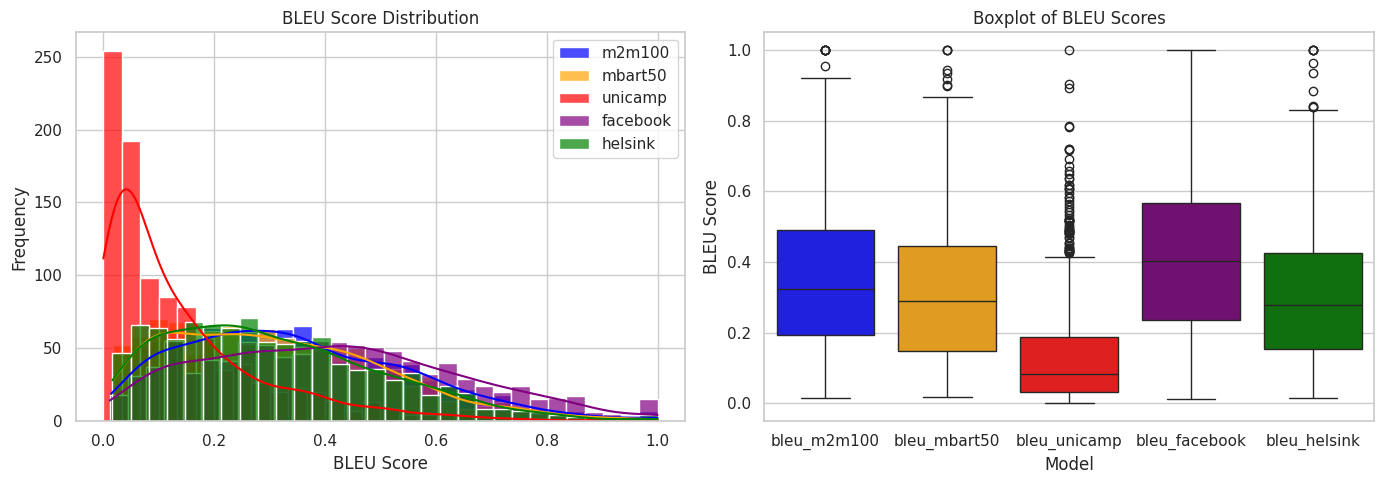

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(14, 5))

# Histograma
plt.subplot(1, 2, 1)
sns.histplot(df_merged["bleu_m2m100"], bins=30, color="blue", kde=True, label="m2m100", alpha=0.7)
sns.histplot(df_merged["bleu_mbart50"], bins=30, color="orange", kde=True, label="mbart50", alpha=0.7)
sns.histplot(df_merged["bleu_unicamp"], bins=30, color="red", kde=True, label="unicamp", alpha=0.7)
sns.histplot(df_merged["bleu_facebook"], bins=30, color="purple", kde=True, label="facebook", alpha=0.7)
sns.histplot(df_merged["bleu_helsink"], bins=30, color="green", kde=True, label="helsink", alpha=0.7)
plt.title("BLEU Score Distribution")
plt.xlabel("BLEU Score")
plt.ylabel("Frequency")
plt.legend()

# Boxplot comparativo
plt.subplot(1, 2, 2)
sns.boxplot(
    data=df_merged[[
        "bleu_m2m100", "bleu_mbart50", "bleu_unicamp", "bleu_facebook", "bleu_helsink"
    ]],
    palette=["blue", "orange", "red", "purple", "green"]
)
plt.title("Boxplot of BLEU Scores")
plt.ylabel("BLEU Score")
plt.xlabel("Model")

plt.tight_layout()
plt.show()